In [76]:
# %pip install numpy torch matplotlib datasets tqdm TorchCRF

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset

# Try to import CRF; if not installed, please install via: pip install torchcrf
try:
    from TorchCRF import CRF
except ImportError:
    raise ImportError("Please install torchcrf using 'pip install torchcrf'.")

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("CUDA available?", torch.cuda.is_available())
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))


model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Part 2: Evaluation Metric Function
def exact_match_score(predictions, references):
    """
    Computes the Exact Match (EM) percentage between predictions and ground truth.
    """
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  # Convert to percentage

# Quick test:
print("EM test:", exact_match_score(["answer", "test"], ["answer", "wrong"]))


Using device: cuda:0
CUDA available? True
CUDA device name: NVIDIA GeForce RTX 4060 Laptop GPU
EM test: 50.0


In [ ]:
# Part 3: Preprocessing Functions 
# Global hyperparameters for tokenization
max_length = 384
doc_stride = 128

def preprocess_baseline(examples):
    """
    Tokenize examples for the baseline QA model.
    For each example, computes:
      - input_ids, attention_mask, token_type_ids
      - start_positions and end_positions (using first answer if available)
      - offset_mapping, context, and answers (replicated for each overflow feature)
    """
    outputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    start_positions = []
    end_positions = []
    new_offset_mapping = []
    new_context = []
    new_answers = []
    
    for i, offset in enumerate(outputs["offset_mapping"]):
        sample_index = outputs["overflow_to_sample_mapping"][i]
        context = examples["context"][sample_index]
        new_context.append(context)
        new_answers.append(examples["answers"][sample_index])
        
        answers = examples["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
        else:
            answer_start = answers["answer_start"][0]
            answer_text = answers["text"][0]
            answer_end = answer_start + len(answer_text)
            token_start_index, token_end_index = None, None
            for idx, (s, e) in enumerate(offset):
                if s <= answer_start < e:
                    token_start_index = idx
                if s < answer_end <= e:
                    token_end_index = idx
                    break
            if token_start_index is None or token_end_index is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(token_start_index)
                end_positions.append(token_end_index)
        new_offset_mapping.append(offset)
    
    outputs["start_positions"] = start_positions
    outputs["end_positions"] = end_positions
    outputs["context"] = new_context
    outputs["offset_mapping"] = new_offset_mapping
    outputs["answers"] = new_answers
    return outputs

def preprocess_crf(examples):
    """
    Tokenize examples for the CRF model.
    For each example, creates:
      - input_ids, attention_mask, token_type_ids, offset_mapping, and context
      - crf_labels: binary labels for each token (1 if token is inside the answer span, 0 otherwise)
      - answers: replicated from the original sample for later evaluation.
    """
    outputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    crf_labels = []
    new_offset_mapping = []
    new_context = []
    new_answers = []
    
    for i, offset in enumerate(outputs["offset_mapping"]):
        sample_index = outputs["overflow_to_sample_mapping"][i]
        context = examples["context"][sample_index]
        new_context.append(context)
        new_answers.append(examples["answers"][sample_index])
        
        answers = examples["answers"][sample_index]
        labels = [0] * len(offset)
        if len(answers["answer_start"]) > 0:
            answer_start = answers["answer_start"][0]
            answer_text = answers["text"][0]
            answer_end = answer_start + len(answer_text)
            for idx, (s, e) in enumerate(offset):
                if s == 0 and e == 0:
                    continue
                if s >= answer_start and e <= answer_end:
                    labels[idx] = 1
        crf_labels.append(labels)
        new_offset_mapping.append(offset)
    
    outputs["crf_labels"] = crf_labels
    outputs["context"] = new_context
    outputs["offset_mapping"] = new_offset_mapping
    outputs["answers"] = new_answers
    return outputs

In [ ]:
# Part 4: Model Definitions
class SpanBERTForQA(nn.Module):
    """
    Standard SpanBERT-based Question Answering model:
      - Uses a pretrained SpanBERT encoder.
      - Predicts start and end logits using a linear layer.
    """
    def __init__(self, model_name):
        super(SpanBERTForQA, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.qa_outputs = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, token_type_ids, start_positions=None, end_positions=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        logits = self.qa_outputs(sequence_output)      # shape: (batch, seq_len, 2)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)         # shape: (batch, seq_len)
        end_logits = end_logits.squeeze(-1)
        loss = None
        if start_positions is not None and end_positions is not None:
            loss_fct = nn.CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            loss = (start_loss + end_loss) / 2
        return loss, start_logits, end_logits



In [ ]:
# Part 5: Answer Reconstruction Functions
def reconstruct_answer(example):
    """
    Reconstructs the predicted answer string for the baseline model using offset mapping.
    Expects:
      - "offset_mapping": list of (start, end) for each token.
      - "context": the original context string.
      - "pred_start" and "pred_end": predicted token indices.
    """
    offset = example["offset_mapping"]
    context = example["context"]
    if example["pred_start"] > example["pred_end"]:
        return ""
    start_char = offset[example["pred_start"]][0]
    end_char = offset[example["pred_end"]][1]
    return context[start_char:end_char]

def reconstruct_answer_crf(example, prediction_labels):
    """
    Reconstructs the answer text for the CRF model using predicted labels and offset mapping.
    Takes the contiguous span between the first and last token labeled as 1.
    """
    offset = example["offset_mapping"]
    context = example["context"]
    indices = [i for i, label in enumerate(prediction_labels) if label == 1]
    if not indices:
        return ""
    start_idx = indices[0]
    end_idx = indices[-1]
    start_char = offset[start_idx][0]
    end_char = offset[end_idx][1]
    return context[start_char:end_char]


In [ ]:
# Part 6: Training and Evaluation Functions
# We add gradient clipping to improve stability (clip_norm = 1.0)
def train_baseline(model, dataloader, optimizer, device, clip_norm=1.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training Baseline"):
        # Move inputs to GPU
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        token_type_ids = batch["token_type_ids"].to(device, non_blocking=True)
        start_positions = batch["start_positions"].to(device, non_blocking=True)
        end_positions = batch["end_positions"].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        loss, _, _ = model(
            input_ids, attention_mask, token_type_ids,
            start_positions, end_positions
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_baseline(model, dataloader, device):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Baseline"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            contexts = batch["context"]
            offset_mappings = batch["offset_mapping"]
            _, start_logits, end_logits = model(input_ids, attention_mask, token_type_ids)
            start_preds = torch.argmax(start_logits, dim=1).cpu().numpy()
            end_preds = torch.argmax(end_logits, dim=1).cpu().numpy()
            for i in range(len(start_preds)):
                example = {
                    "offset_mapping": offset_mappings[i],
                    "context": contexts[i],
                    "pred_start": int(start_preds[i]),
                    "pred_end": int(end_preds[i]),
                }
                pred_answer = reconstruct_answer(example)
                predictions.append(pred_answer)
                ans = batch["answers"][i]["text"][0] if len(batch["answers"][i]["text"]) > 0 else ""
                references.append(ans)
    return exact_match_score(predictions, references)

def train_crf(model, dataloader, optimizer, device, clip_norm=1.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training CRF"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        crf_labels = batch["crf_labels"].to(device)
        loss, _ = model(input_ids, attention_mask, token_type_ids, crf_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_crf(model, dataloader, device):
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating CRF"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            contexts = batch["context"]
            offset_mappings = batch["offset_mapping"]
            _, pred_labels = model(input_ids, attention_mask, token_type_ids)
            for i in range(len(pred_labels)):
                example = {
                    "offset_mapping": offset_mappings[i],
                    "context": contexts[i],
                }
                pred_answer = reconstruct_answer_crf(example, pred_labels[i])
                predictions.append(pred_answer)
                ans = batch["answers"][i]["text"][0] if len(batch["answers"][i]["text"]) > 0 else ""
                references.append(ans)
    return exact_match_score(predictions, references)

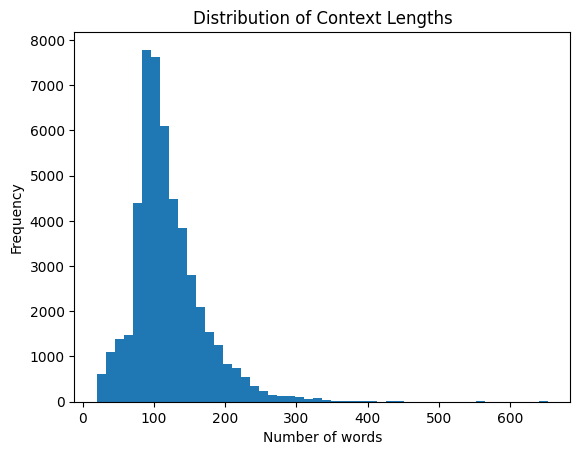

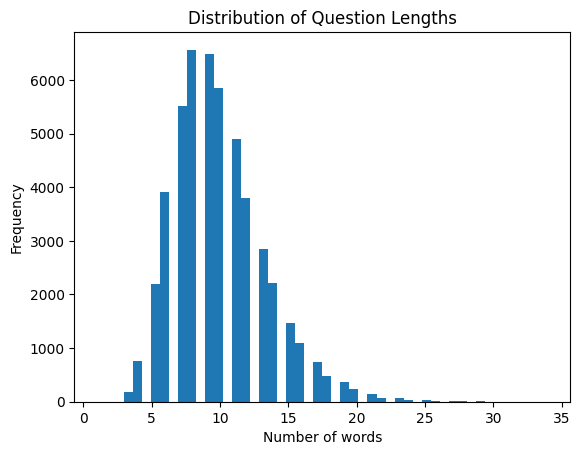

<Figure size 640x480 with 0 Axes>

In [ ]:
# Part 7: Data Loading and Exploratory Data Analysis (EDA)
# Load SQuAD v2 dataset and select subsets:
# Training: 50k samples; Validation: 15k samples
dataset = load_dataset("squad_v2")
train_dataset = dataset["train"].shuffle(seed=seed).select(range(50000))
dev_dataset = dataset["validation"].shuffle(seed=seed).select(range(10000))

# EDA: Plot distribution of context lengths
context_lengths = [len(x.split()) for x in train_dataset["context"]]
plt.hist(context_lengths, bins=50)
plt.title("Distribution of Context Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("context_length_distribution.png")
plt.show()
plt.clf()

# EDA: Plot distribution of question lengths
question_lengths = [len(x.split()) for x in train_dataset["question"]]
plt.hist(question_lengths, bins=50)
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.savefig("question_length_distribution.png")
plt.show()
plt.clf()

In [ ]:
# Part 8: Tokenizer Initialization and Data Preprocessing 
# (Re)initialize the tokenizer (if needed)
model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

print("Preprocessing data for the baseline model...")
# Remove only the unnecessary columns; keep "answers" and "context"
remove_cols = ["question", "title", "id"]

# Map the preprocessing functions for the baseline model
train_baseline_features = train_dataset.map(preprocess_baseline, batched=True, remove_columns=remove_cols)
dev_baseline_features = dev_dataset.map(preprocess_baseline, batched=True, remove_columns=remove_cols)

# Set the format: convert selected columns to torch tensors, but keep all columns (like "answers") in original format.
train_baseline_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions", "offset_mapping", "context"],
    output_all_columns=True
)
dev_baseline_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "start_positions", "end_positions", "offset_mapping", "context"],
    output_all_columns=True
)

print("Preprocessing data for the CRF model...")
# Map the preprocessing functions for the CRF model
train_crf_features = train_dataset.map(preprocess_crf, batched=True, remove_columns=remove_cols)
dev_crf_features = dev_dataset.map(preprocess_crf, batched=True, remove_columns=remove_cols)

train_crf_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "crf_labels", "offset_mapping", "context"],
    output_all_columns=True
)
dev_crf_features.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "crf_labels", "offset_mapping", "context"],
    output_all_columns=True
)


Preprocessing data for the baseline model...
Preprocessing data for the CRF model...


In [ ]:
# Part 9: Create DataLoaders with a Custom Collate Function
def custom_collate(batch):
    """
    Custom collate function that stacks tensor fields but leaves other fields as a list.
    """
    collated = {}
    # Define the keys that should be stacked into tensors.
    numeric_keys = ["input_ids", "attention_mask", "token_type_ids", 
                    "start_positions", "end_positions", "crf_labels"]
    for key in batch[0]:
        if key in numeric_keys and key in batch[0]:
            collated[key] = torch.stack([b[key] for b in batch])
        else:
            # For keys like "offset_mapping", "context", and "answers", keep them as lists.
            collated[key] = [b[key] for b in batch]
    return collated

# Set batch sizes
train_bs = 8  # training batch size
dev_bs = 8    # validation batch size

# Create DataLoaders using the custom collate function
train_baseline_loader = DataLoader(train_baseline_features, batch_size=train_bs, shuffle=True, collate_fn=custom_collate)
dev_baseline_loader = DataLoader(dev_baseline_features, batch_size=dev_bs, collate_fn=custom_collate)

train_crf_loader = DataLoader(train_crf_features, batch_size=train_bs, shuffle=True, collate_fn=custom_collate)
dev_crf_loader = DataLoader(dev_crf_features, batch_size=dev_bs, collate_fn=custom_collate)


# Patched CRF and Model Definition for CRF Model
# Import the base CRF from torchcrf
from TorchCRF import CRF as BaseCRF

# Define a patched CRF class that avoids problematic in-place operations.
class PatchedCRF(BaseCRF):
    def __init__(self, num_labels, pad_idx):
        # Call the parent's constructor.
        super().__init__(num_labels, pad_idx)
    def _initialize_parameters(self, pad_idx):
        # Instead of performing in-place modifications on leaf variables,
        # we simply initialize the parameters uniformly.
        with torch.no_grad():
            nn.init.uniform_(self.start_trans, -0.1, 0.1)
            nn.init.uniform_(self.trans_matrix, -0.1, 0.1)
        # Note: We are not zeroing out transitions for a pad label here,
        # since for our binary labeling we do not designate a pad token.

# Define the SpanBERT-CRF model using our patched CRF.
class SpanBERTCRFForQA(nn.Module):
    """
    SpanBERT-CRF model:
      - Uses a pretrained SpanBERT encoder.
      - Applies a linear layer for token-level classification (2 classes).
      - Uses a CRF layer (patched) to decode the best label sequence.
    """
    def __init__(self, model_name):
        super(SpanBERTCRFForQA, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        # Use the patched CRF; we pass pad_idx as 0 (this value will not be used specially).
        self.crf = PatchedCRF(2, 0)
        
    def forward(self, input_ids, attention_mask, token_type_ids, crf_labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        emissions = self.classifier(sequence_output)   # shape: (batch, seq_len, num_tags)
        if crf_labels is not None:
            # Compute the negative log-likelihood loss.
            loss = -self.crf(emissions, crf_labels, mask=attention_mask.bool(), reduction='mean')
            return loss, None
        else:
            # Decode the best sequence.
            prediction = self.crf.decode(emissions, mask=attention_mask.bool())
            return None, prediction

# Part 10: Model Initialization
# Initialize your models (the baseline model remains unchanged)
baseline_model = SpanBERTForQA(model_name).to(device)
crf_model = SpanBERTCRFForQA(model_name).to(device)

print("Models initialized successfully.")

# Part 11: Optimizers and Schedulers
epochs = 6

# Baseline model optimizer and scheduler
total_steps_baseline = len(train_baseline_loader) * epochs
optimizer_baseline = AdamW(baseline_model.parameters(), lr=3e-5)
scheduler_baseline = get_linear_schedule_with_warmup(optimizer_baseline, num_warmup_steps=0, num_training_steps=total_steps_baseline)

# CRF model optimizer and scheduler
total_steps_crf = len(train_crf_loader) * epochs
optimizer_crf = AdamW(crf_model.parameters(), lr=3e-5)
scheduler_crf = get_linear_schedule_with_warmup(optimizer_crf, num_warmup_steps=0, num_training_steps=total_steps_crf)

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models initialized successfully.


In [ ]:
# Part 12: Training Loop for Baseline Model
baseline_train_losses = []
baseline_val_em = []

print("Training Baseline SpanBERT Model...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    # Train on the GPU
    train_loss = train_baseline(
        baseline_model, 
        train_baseline_loader, 
        optimizer_baseline, 
        device=device, 
        clip_norm=1.0
    )
    baseline_train_losses.append(train_loss)
    
    # Evaluate on the GPU
    val_em = evaluate_baseline(
        baseline_model, 
        dev_baseline_loader, 
        device=device
    )
    baseline_val_em.append(val_em)
    
    print(f"Baseline Epoch {epoch+1} - Training Loss: {train_loss:.4f}, Validation EM: {val_em:.2f}%")
    scheduler_baseline.step()


Training Baseline SpanBERT Model...
Epoch 1/6


Evaluating Baseline: 100%|██████████| 1296/1296 [02:51<00:00,  7.54it/s]


Baseline Epoch 1 - Training Loss: 1.9621, Validation EM: 58.86%
Epoch 2/6


Evaluating Baseline: 100%|██████████| 1296/1296 [02:51<00:00,  7.56it/s]


Baseline Epoch 2 - Training Loss: 1.3767, Validation EM: 59.40%
Epoch 3/6


Evaluating Baseline: 100%|██████████| 1296/1296 [02:48<00:00,  7.69it/s]


Baseline Epoch 3 - Training Loss: 1.1219, Validation EM: 60.12%
Epoch 4/6


Evaluating Baseline: 100%|██████████| 1296/1296 [02:46<00:00,  7.77it/s]


Baseline Epoch 4 - Training Loss: 0.9608, Validation EM: 61.14%
Epoch 5/6


Evaluating Baseline: 100%|██████████| 1296/1296 [02:48<00:00,  7.68it/s]


Baseline Epoch 5 - Training Loss: 0.8518, Validation EM: 58.89%
Epoch 6/6


Evaluating Baseline: 100%|██████████| 1296/1296 [03:02<00:00,  7.10it/s]

Baseline Epoch 6 - Training Loss: 0.7713, Validation EM: 62.36%


In [ ]:
import torch

# Specify the checkpoint file name (you can adjust the epoch number as needed)
# checkpoint_path = "Baseline_model_epoch_6.pth"
# torch.save(crf_model.state_dict(), checkpoint_path)
# print(f"Saved CRF model checkpoint to {checkpoint_path}")

# Print a detailed GPU memory summary.
# This will show which tensors (if any) are still allocated.
print("GPU Memory Summary:")
print(torch.cuda.memory_summary(device=device, abbreviated=False))

# Optionally, free GPU memory by deleting the model and clearing cache.
del baseline_model
torch.cuda.empty_cache()
print("Cleared CRF model from GPU memory.")


GPU Memory Summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14143 MiB |  14145 MiB | 283986 GiB | 283972 GiB |
|       from large pool |  14125 MiB |  14127 MiB | 280251 GiB | 280237 GiB |
|       from small pool |     18 MiB |     19 MiB |   3734 GiB |   3734 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  14143 MiB |  14145 MiB | 283986 GiB | 283972 GiB |
|       from large pool |  14125 MiB |  1412

NameError: name 'baseline_model' is not defined

In [ ]:

import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModel

# If needed, import your TorchCRF:
from TorchCRF import CRF  # <-- from the TorchCRF library you installed

# 1) Define a new SpanBERTCRFForQA class that doesnt disturb the last running
# ------------------------------------------------------------------
class SpanBERTCRFForQA(nn.Module):
    """
    SpanBERT-CRF model using TorchCRF (which doesn't support 'reduction' arg).
    We handle the mean reduction ourselves.
    """
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        # Instantiate the CRF: (num_tags=2, pad_idx=0, use_gpu=...)
        # Adjust pad_idx if needed. Typically for 2 labels, 0 is "not answer," 1 is "answer."
        self.crf = CRF(num_tags=2, pad_idx=0, use_gpu=torch.cuda.is_available())

    def forward(self, input_ids, attention_mask, token_type_ids, crf_labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        emissions = self.classifier(sequence_output) # shape: (batch, seq_len, num_tags)

        if crf_labels is not None:
            # TorchCRF's forward returns either a scalar or a vector of shape [batch_size].
            # We'll call it nll (negative log-likelihood).
            nll = self.crf(emissions, crf_labels, mask=attention_mask.bool())
            # If it's a vector of length batch_size, we average it here:
            if nll.dim() > 0:  
                nll = nll.mean()
            loss = -nll
            return loss, None
        else:
            # Decode the best tag sequence for each sample
            best_paths = self.crf.decode(emissions, mask=attention_mask.bool())
            return None, best_paths

# 2) Define new training and evaluation functions for the CRF model
# ------------------------------------------------------------------
def train_crf_fixed(model, dataloader, optimizer, device, clip_norm=1.0):
    """
    Train loop for the CRF model. Moves inputs to GPU, 
    calls model forward without 'reduction' arg, and does gradient steps.
    """
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training CRF"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        crf_labels = batch["crf_labels"].to(device)

        loss, _ = model(input_ids, attention_mask, token_type_ids, crf_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate_crf_fixed(model, dataloader, device, reconstruct_answer_crf_fn, exact_match_fn):
    """
    Evaluation loop for the CRF model. Moves inputs to GPU, 
    decodes predictions, reconstructs answers, and computes EM.
    
    :param reconstruct_answer_crf_fn: function(example, predicted_labels) -> str
    :param exact_match_fn: function(list_of_preds, list_of_refs) -> float
    """
    model.eval()
    predictions = []
    references = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating CRF"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            
            # These remain on CPU (lists of python objects).
            offset_mappings = batch["offset_mapping"]
            contexts = batch["context"]
            answers = batch["answers"]  # If you stored them

            _, pred_labels = model(input_ids, attention_mask, token_type_ids)
            
            for i, labels in enumerate(pred_labels):
                example = {
                    "offset_mapping": offset_mappings[i],
                    "context": contexts[i]
                }
                pred_answer = reconstruct_answer_crf_fn(example, labels)
                predictions.append(pred_answer)
                # Ground truth reference:
                ref = answers[i]["text"][0] if len(answers[i]["text"]) > 0 else ""
                references.append(ref)
    
    # Compute exact match
    return exact_match_fn(predictions, references)


crf_train_losses = []
crf_val_em = []

print("Training SpanBERT-CRF Model...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_crf_fixed(crf_model, train_crf_loader, optimizer_crf, device, clip_norm=1.0)
    crf_train_losses.append(train_loss)
    
    val_em = evaluate_crf_fixed(crf_model, dev_crf_loader, device, reconstruct_answer_crf, exact_match_score)
    crf_val_em.append(val_em)
    
    print(f"CRF Epoch {epoch+1} - Training Loss: {train_loss:.4f}, Validation EM: {val_em:.2f}%")
    scheduler_crf.step()


Training SpanBERT-CRF Model...
Epoch 1/6


Training CRF:   0%|          | 0/6373 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.81 GiB is allocated by PyTorch, and 736.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

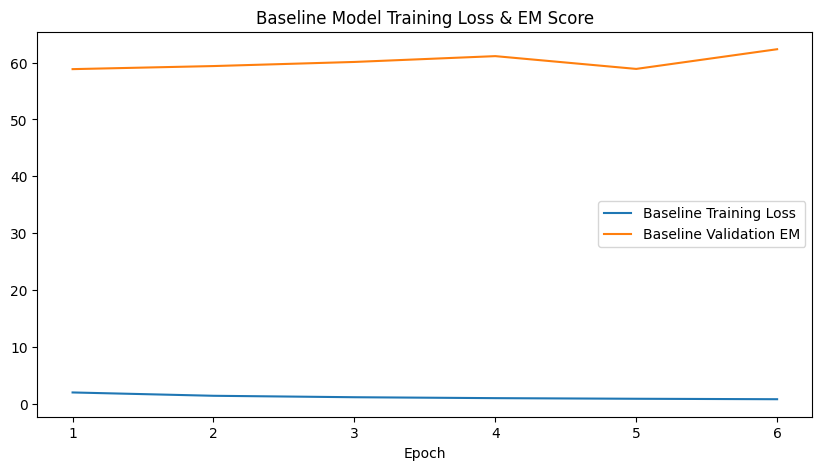

<Figure size 640x480 with 0 Axes>

In [ ]:
# Part 14: Plot Training Curves and Final Evaluation
epochs_range = range(1, epochs + 1)

# Plot Baseline Model curves
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, baseline_train_losses, label="Baseline Training Loss")
plt.plot(epochs_range, baseline_val_em, label="Baseline Validation EM")
plt.title("Baseline Model Training Loss & EM Score")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("baseline_training_plot.png")
plt.show()
plt.clf()

# Plot CRF Model curves
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, crf_train_losses, label="CRF Training Loss")
plt.plot(epochs_range, crf_val_em, label="CRF Validation EM")
plt.title("CRF Model Training Loss & EM Score")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("crf_training_plot.png")
plt.show()
plt.clf()

# Final evaluation on the validation set
final_baseline_em = evaluate_baseline(baseline_model, dev_baseline_loader, device)
final_crf_em = evaluate_crf(crf_model, dev_crf_loader, device)
print(f"Final Baseline Model EM: {final_baseline_em:.2f}%")
print(f"Final CRF Model EM: {final_crf_em:.2f}%")
